# COGS 108 - Final Project 

# Overview

In this project I explored the possible connection between average health inspections at food locations and online customer reviews for the same location. Through my analysis, I attempted to determine whether any possible correlation between the two variables was significant. At the conclusion of my analysis, I found that the data analyzed did not show a significant connection between the variables and concluded there was no correlation between the two.

# Name & GitHub

- Name: Tylan Wilson
- GitHub Username: tylanrwilson

# Research Question

What kind of correlation, if any, exists between the average score of inspections at a given location and the average reviews on Yelp for that same location?

## Background and Prior Work

In researching the public health restaurant inspection system, the baseline frequency I found was that inspections are mandated once every six months at a minimum with additionally inspections being conducted as a result of customer complaints. Looking further into the specific details of health inspections, I found a listing of all the different specific types of inspections. The full list of different types of inspections are: Routine, Follow-Up, HACCP, Complaint, Pre-Operational, License Renewal, and Other inspections (1). The knowledge about the workings of the inspection system could be of great value in interpreting the data collected and determining what pieces of data are the most important. I also went and found further information about the inspection process and scoring, finding that inpections are done on a 100 point scale and points are removed with each infraction by the business. The scaling of these point values are similar to letter grading scale, with 90-100 points being an A, 80-89 points being a B, 70-79 points being a C, and anything below that resulting in the perimit for the establishment being revoked (2).

Additionally, I researched existing work done surrounding inspections and the data around them. In a public health report published in 2017, there was an investigation conducted to determine the link between "inspection frequency and restaurant neighborhood sociodemographic characteristics," (3). In the report they looked at the restaurant inspections in Philadelphia, Pennsylvania from 2013-2014, gathering data about restaurant type (chain or not), number of inspections, and the particular violations in each inspection. They found through their data that chain restaurants had fewer violations in their inspections, however smaller restaurants had a significant decrease in violations with a greater number of inspections. This data is similar to the type of data that I would hopw to work with to answer my question but I would connect it with different pieces of information.

References:
- 1) Understanding Food Establishment Inspections https://dchealth.dc.gov/service/understanding-food-establishment-inspections
- 2) The ABCs of restaurant food grades https://www.courier-tribune.com/article/20140830/news/308309822
- 3) Inspection Frequency, Sociodemographic Factors, and Food Safety Violations in Chain and Nonchain Restaurants, Philadelphia, Pennsylvania, 2013-2014 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/

# Hypothesis


My hypothesis for this data is that there will be a positive correlation between the scores of the inspections and the reviews of the restaurant due to the idea that most people hold clenliness as a high standard of importance, especially in relation to food. Higher inspections are indicative of a higher level of cleanliness and this should in turn lead to greater customer satisfaction, resulting in higher ratings of the establishment.

# Dataset(s)

The data used to explore this question is all health and food inspection data, as well as review data on each of the locations via the online website Yelp. This data will be cleaned and explored, taking data from each of the different data sets in order to begin to look at a possible answer to the proposed question.

- Dataset Name: Restaurants
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?wrap=1
- Number of observations: 3324

This dataset is a set of base information about each of restaurants, with general information data about them such as phone number, location, etc. It also contains ID numbers corresponding to the Inspections dataset.

- Dataset Name: Inspections
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?wrap=1
- Number of observations: 18466

This dataset is a set of health and food inspections done containing both information about the location of the establishment that the inspection took place at, as well as information about both the inspector and various other pieces of information about the inspection itself such as score and different violations. 

- Dataset Name: Yelp
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files/1639871/download?wrap=1
- Number of observations: 3688

This dataset contains the information about the online reviews of the establishments, including data about the locations, what type of food it serves, overall ratings, price, etc. 

I plan to combine information from all of these sets together, taking pieces of each set in order to fully explore the question being analyzed, taking the base restaurant ID and names in order to bring together the insepction scores and review scores

# Setup

In [1]:
## YOUR CODE HERE
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
restaurants_df = pd.read_csv('restaurants.csv')
reviews_df = pd.read_csv('yelp.csv')
inspections_df = pd.read_csv('inspections.csv')

# Data Cleaning

In cleaning the data I had to remove lots of extraneous information from all of the datasets as I was only interested in the basic restaurant data from the first set, the indpection scores from the second set, and the review scores from the third data set. I performed basic cleaning of both the names and addresses through a basic string cleaning function which allowed for the standardization of these strings between different datasets. In addition, I reduced the sample size contained in each of the datasets by removing duplicate values in order to create easier combination of data later. 

In [3]:
def lowerString(string):
    string = str(string)
    string = string.lower()
    string = string.strip()
    return string

In [4]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
rest_clean_df = restaurants_df.drop(columns = ['X.objectid', 'address2', 'city', 'state', 'postalcode', 'phonenumber', 'restaurantopendate', 'facilitytype', 'x', 'y', 'geocodestatus'])
rest_clean_df['address1'] = rest_clean_df['address1'].apply(lowerString)
rest_clean_df['name'] = rest_clean_df['name'].apply(lowerString)
rest_clean_df = rest_clean_df.drop_duplicates(subset = ['address1'], keep=False).sort_values(by=['address1'])
rest_clean_df = rest_clean_df.drop_duplicates(subset = ['name'], keep = 'first')
rest_clean_df

,hsisid,name,address1
2306,4092040178,all american hot dogs (wcid #125),000 block jones st
1604,4092011142,east village bar & grill,1 dixie trl
1777,4092015668,quiznos,1 exchange plaza
1539,4092010688,state hwy buidling lunchenette,1 s wilmington st
1950,4092017226,red robin #688,10 cabela dr
...,...,...,...
320,4092030221,backyard bistro #1 (wcid #267),hillsborough st
183,4092014332,emc2,one technology dr
2479,4092030133,tacos el corral #4 (wc #122),rock quarry rd
749,4092040294,carolina classic hot dogs (wcid #467),williams st


In [5]:
rev_clean_df = reviews_df.drop(columns=['id', 'is_closed', 'review_count', 'zip_code', 'latitude', 'longitude', 'price', 'phone', 
       'hotdogs', 'sandwiches', 'pizza', 'tradamerican', 'burgers', 'mexican', 'grocery',
       'breakfast_brunch', 'coffee', 'chinese', 'italian', 'newamerican',
       'chicken_wings', 'delis', 'bars', 'salad', 'seafood', 'bbq', 'bakeries',
       'sushi'])
rev_clean_df[rev_clean_df.isnull().any(axis=1)]
rev_clean_df = rev_clean_df.dropna(subset=['address1'])
rev_clean_df['address1'] = rev_clean_df['address1'].apply(lowerString)
rev_clean_df['name'] = rev_clean_df['name'].apply(lowerString)
rev_clean_df = rev_clean_df.drop_duplicates(subset = ['address1'], keep=False).sort_values(by=['address1'])
rev_clean_df = rev_clean_df.drop_duplicates(subset = ['name'], keep = 'first')
rev_clean_df

,name,rating,address1
2605,east village grill & bar,3.0,1 dixie trl
2079,north carolina state capitol,4.0,1 e edenton st
2847,quiznos,3.0,1 exchange plz
2851,the morning times,4.0,10 e hargett st
3568,groucho's deli of raleigh,4.0,10 horne st
...,...,...,...
3428,southern season,4.0,university mall - 201 s estes dr
1163,park west village,4.0,village market pl
294,au bon pain,3.5,wake med hospital
3643,italian pizzeria,3.5,willowdaile shopping ctr


In [6]:
insp_clean_df = inspections_df.drop(columns=['date', 'address1', 'address2', 'city', 'state',
       'postalcode', 'phonenumber', 'restaurantopendate',
       'days_from_open_date', 'facilitytype', 'x', 'y', 'geocodestatus', 'zip',
       'type', 'description', 'inspectedby', 'inspection_num', 'inspector_id',
       'previous_inspection_date', 'days_since_previous_inspection',
       'previous_inspection_by_same_inspector', 'num_critical',
       'num_non_critical', 'num_critical_previous',
       'num_non_critical_previous', 'num_critical_mean_previous',
       'num_non_critical_mean_previous', 'avg_neighbor_num_critical',
       'avg_neighbor_num_non_critical', 'top_match', 'second_match',
       'critical'])
insp_clean_df

,hsisid,name,score
0,4092013748,Cafe 3000 At Wake Med,96.0
1,4092014046,Overtime Sports Pub,98.0
2,4092015191,TASTE OF CHINA,97.0
3,4092016122,Panera Bread #1643,99.0
4,4092021513,WalMart Supercenter #4499-00 Deli/Bakery,97.0
...,...,...,...
18461,4092021142,Sino Wok,93.0
18462,4092110100,Weatherstone Elem. Sch. Cafeteria,97.0
18463,4092110487,ALSTON RIDGE ELEMENTARY SCHOOL CAFETERIA,96.0
18464,4092300177,Food Lion #996 Meat Market,99.0


# Data Analysis & Results

The first step in analyzing the data was creating a master dataframe that would combine all of the necessary data into one place in order to easily access all required data for analysis. Then I went on to calculate the average inspection score for each location based on however many inspections were present in the dataset for that location. If a location had no recorded inspections then the value was set to -1.

In [7]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
full_df = rest_clean_df
full_df['averageInspScore'] = -1
for x in full_df['hsisid']:
    average=0
    count=0
    for i in insp_clean_df[insp_clean_df['hsisid']==x]['score']:
        average = average+i
        count = count+1
    if count == 0:
        full_df['averageInspScore'][full_df['hsisid']==x] = -1
    else:
        average = average/count
        full_df['averageInspScore'][full_df['hsisid']==x] = average
full_df

,hsisid,name,address1,averageInspScore
2306,4092040178,all american hot dogs (wcid #125),000 block jones st,-1.000000
1604,4092011142,east village bar & grill,1 dixie trl,92.833333
1777,4092015668,quiznos,1 exchange plaza,95.416667
1539,4092010688,state hwy buidling lunchenette,1 s wilmington st,97.571429
1950,4092017226,red robin #688,10 cabela dr,97.500000
...,...,...,...,...
320,4092030221,backyard bistro #1 (wcid #267),hillsborough st,-1.000000
183,4092014332,emc2,one technology dr,-1.000000
2479,4092030133,tacos el corral #4 (wc #122),rock quarry rd,-1.000000
749,4092040294,carolina classic hot dogs (wcid #467),williams st,-1.000000


I then removed all locations with a -1 inspection score as they had no data and therefore were not relevant in the analysis

In [8]:
full_df = full_df[full_df['averageInspScore']!=-1]
full_df

,hsisid,name,address1,averageInspScore
1604,4092011142,east village bar & grill,1 dixie trl,92.833333
1777,4092015668,quiznos,1 exchange plaza,95.416667
1539,4092010688,state hwy buidling lunchenette,1 s wilmington st,97.571429
1950,4092017226,red robin #688,10 cabela dr,97.500000
2922,4092016649,groucho's deli,10 horne st,99.400000
...,...,...,...,...
2796,4092016444,sheetz #513,9915 fayetteville rd,98.900000
3017,4092016565,bojangles #49,9919 fayetteville st,96.000000
99,4092016485,zaxby's #46101,995 durham rd,96.857143
941,4092016484,dunkin donuts #351119,999 durham rd,93.700000


I then went on to add the online review scores, assigning a default value again of -1 in order to weed out any locations not present in the review dataset

In [9]:
full_df['reviewScore'] = -1

for x in full_df['address1']:
    if x in list(rev_clean_df['address1']):
        full_df['reviewScore'][full_df['address1']==x] = rev_clean_df['rating'][rev_clean_df['address1']==x].values

full_df

,hsisid,name,address1,averageInspScore,reviewScore
1604,4092011142,east village bar & grill,1 dixie trl,92.833333,3.0
1777,4092015668,quiznos,1 exchange plaza,95.416667,-1.0
1539,4092010688,state hwy buidling lunchenette,1 s wilmington st,97.571429,-1.0
1950,4092017226,red robin #688,10 cabela dr,97.500000,-1.0
2922,4092016649,groucho's deli,10 horne st,99.400000,4.0
...,...,...,...,...,...
2796,4092016444,sheetz #513,9915 fayetteville rd,98.900000,-1.0
3017,4092016565,bojangles #49,9919 fayetteville st,96.000000,-1.0
99,4092016485,zaxby's #46101,995 durham rd,96.857143,-1.0
941,4092016484,dunkin donuts #351119,999 durham rd,93.700000,-1.0


I then removed all locations without review data and reorganized the dataframe according to index

In [10]:
full_df = full_df[full_df['reviewScore']!=-1]
full_df = full_df.sort_index()
full_df

,hsisid,name,address1,averageInspScore,reviewScore
3,4092015333,the remedy diner,137 e hargett st,94.000000,4.0
6,4092016679,bittersweet,16 e martin st,99.400000,4.0
9,4092010037,aubrey & peedi`s grill,38 n main st,96.400000,4.5
19,4092014398,skipper`s fish fry and market,1001 e williams st,96.500000,4.0
27,4092014271,salvio`s pizzeria,2428 sw cary pkwy,94.187500,4.0
...,...,...,...,...,...
3305,4092021511,harris teeter #330 produce,1151 tryon village dr,98.625000,3.0
3310,4092021619,little caesars #1908-0013,100 wakelon st,94.928571,4.0
3313,4092016359,dean's seafood grill,1080 darrington dr,98.000000,3.5
3314,4092016368,golden palace,4420 capital blvd,90.000000,3.5


I plotted a basic histogram of the distribution of review scores present in the data, finding in looking at the graph that the most common score was a 4.0 and most scores tended to be at the higher end of the spectrum, having no scores present in the 1.0 and below range. 

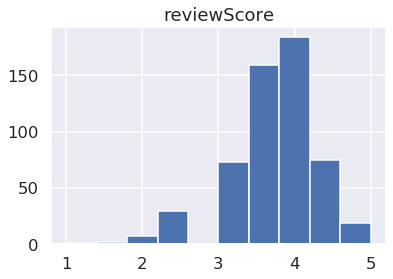

In [11]:
full_df.hist(column = 'reviewScore')
f2 = plt.gcf()

I plotted a basic histogram of the distribution of average inspection scores present in the data, finding in looking at the graph that the most common score was around ~97 and most scores tended to be at the higher end of the spectrum, having no scores present below around 87. This is to be expected for the most part as low scores in the inspection would result in a closure of the establishment and therefore this low score would not be present in the data. 

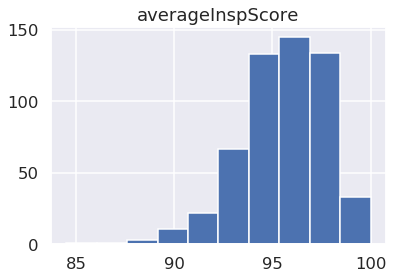

In [12]:
full_df.hist(column = 'averageInspScore')
f2 = plt.gcf()

Here I plotted the review scores against the inspection scores to see if there is any type of relationship between the two variables. In plotting the two against each other it seemed as though there might be some sort of connection in an upward trend so I created a fit line to try to plot out the relationship. However, while the line did show an upward trend, it was still unclear if this was truly a relationship between the two variables.

In [13]:
a1, b1 = np.polyfit(full_df['averageInspScore'], full_df['reviewScore'], 1)
averagevals = np.arange(min(full_df['averageInspScore']),max(full_df['averageInspScore']))

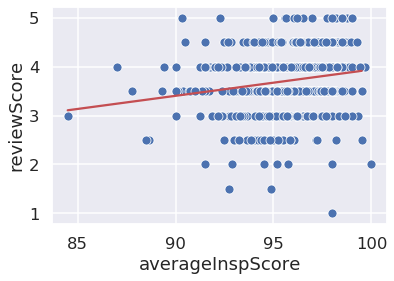

In [14]:
sns.scatterplot(x='averageInspScore', y='reviewScore', data = full_df)
rvals = a1*averagevals+b1
plt.plot(averagevals, rvals, 'r')

f3 = plt.gcf()

In order to fully dertermine if there was a relationship between the two variables I constructed a linear model in order to test if there was a significant correlation between the variables. In constructing and testing the model I found that based on a 0.01 alpha value the model showed that there was no significant correlation between the variables.

In [15]:
outcome_1, predictors_1 = patsy.dmatrices('reviewScore ~ averageInspScore', full_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:            reviewScore   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     19.56
Date:                Tue, 09 Jun 2020   Prob (F-statistic):           1.17e-05
Time:                        00:13:30   Log-Likelihood:                -517.78
No. Observations:                 550   AIC:                             1040.
Df Residuals:                     548   BIC:                             1048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.4361      1.162  

# Ethics & Privacy

The main privacy concerns that have to be dealt with in doing this type of data analysis are the removal of any personally identifiable information that could be tied to individuals in specific restaurant locations. Additionally, it is important to make sure that the data about inspections is data that is publicly available for use and would not be violating any privacy laws in using it. A possible bias that could come from the data could be based on the location if a certain area tends to have different characteristics that would be outside the average elsewhere. Another issue that could come up with a certain location being an outlier could be an individual inspection office being too strict or lax in their inspections and possibly skewing that set of data.

The best way to handle these issues would be to be careful inspecting potential datasets to work with and make sure that the data collected was all collected in a way that is legal and ethical, only using figures that come with the entity's consent. In addition, it is also important to look at the locational aspect and ensure that there is enough representation of a variety of different areas to reduce the possible bias that could come from a unique problem in a single area. 

In these specific datasets, the steps taken to make the analysis ethical and protect the privacy of the esyablishments is that all individually identifiable information has been stripped from the data. The only identifier left in the data is a unique numberical ID to be used to connect the specific establishment to its reviews and inspections, the name of the establishment, and the street address of each location, stripped of more general information such as city or zip-code.

# Conclusion & Discussion

In conclusion, the cleaning and analysis of the data showed that my hypothesis that higher inspection scores would be positively correlated with review scores was incorrect, as there was shown to be no conclusive relationship between the two variables. The original question sought to explore if any kind of relationship existed between the inspection scores and the review scores. While both sets of data trended toward the higher end of the set rather than the lower end, statistical testing showed no significant causal relationship between the two. In my analysis I explored both the overall distribution of each variable individually, and then plotting the two against each other, attempting to plot a fit line through the data. Then, due to the inconclusivity of the graphs, upon using a linear model to determine significance I found that there was no statistically significant correlation between the variables. 

There are certainly limitations to the anaylsis due to multiple factors such as extreneous details surrounding the circumstances of the review scores, as well as the crunch for time in completing the analysis. For example, customer-employee interactions could have a significant influence on the review scores and these types of things would not be statistically recorded in the data. Expanded datasets and more information surrounding the datasets could be helpful in further analysis of the subject. In addition, deeper analysis of the given data including exploring the individual violations in inspections could be helpful in expanding the analysis of the question.

This work could help to draw further attention to the importance of cleanliness and proper health and safety precautions as it relates to overall customer satisfaction. Further research in the subject could help change coorperate policies if it is shown  that these principles are important enough to the consumer. 